# Figures for FairCal based on Salvador et al., 2022
## Reproduced by Group 42 of FACT-AI 2022/23 @ UvA

### Figures Reproduced

1. Violin plots (Distribution of cosine similarity scores for genuine and imposter pairs, by subgroup)
2. Fairness plots (Global FPR vs Subgroup-specific FPR)

### Imports

In [3]:
!pip install cvxpy
!pip install pycave

  Using cached pycave-3.2.1-py3-none-any.whl (37 kB)
  Using cached lightkit-0.5.0-py3-none-any.whl (17 kB)
  Using cached pytorch_lightning-1.9.0-py3-none-any.whl (825 kB)
  Using cached torchmetrics-0.11.0-py3-none-any.whl (512 kB)
  Using cached lightning_utilities-0.6.0-py3-none-any.whl (18 kB)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import pickle

from approaches import baseline, cluster_methods, oracle
from approaches_ftc import ftc
from approaches_agenda import agenda

### Loading cosine similarities (settings: rfw, facenet-webface, beta calibration)

In [10]:
db = pd.read_csv('data/rfw/rfw_w_sims.csv')
dataset_name = 'rfw'
features = ['facenet-webface']
feature = 'facenet-webface'
calibration_method = 'beta'
nbins = 25
n_clusters = 100

In [11]:
display(db.head())

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id1,num1,id2,num2,ethnicity,pair,same,fold,facenet,facenet-webface,arcface,image_id_1_clean,image_id_2_clean,unique_key
0,0,0,0,m.0g5ty_,1,m.0g5ty_,2,African,Genuine,True,0,0.733062,0.610138,NaN,m.0g5ty__1,m.0g5ty__2,m.0g5ty__1_m.0g5ty__2
1,1,1,1,m.05q5bqf,2,m.05q5bqf,3,African,Genuine,True,0,0.656041,0.536733,NaN,m.05q5bqf_2,m.05q5bqf_3,m.05q5bqf_2_m.05q5bqf_3
2,2,2,2,m.03yfnz5,2,m.03yfnz5,1,African,Genuine,True,0,0.624838,0.631015,NaN,m.03yfnz5_2,m.03yfnz5_1,m.03yfnz5_2_m.03yfnz5_1
3,3,3,3,m.03npynb,2,m.03npynb,3,African,Genuine,True,0,0.635635,0.593042,NaN,m.03npynb_2,m.03npynb_3,m.03npynb_2_m.03npynb_3
4,4,4,4,m.0h1f_hh,1,m.0h1f_hh,3,African,Genuine,True,0,0.788073,0.695494,NaN,m.0h1f_hh_1,m.0h1f_hh_3,m.0h1f_hh_1_m.0h1f_hh_3


In [12]:
subgroups = {'ethnicity': ['African', 'Asian', 'Caucasian', 'Indian']}
sensitive_attributes = {'ethnicity': ['ethnicity', 'ethnicity']}
fold = 5

In [13]:
# title_features = {
#     'facenet':'FaceNet (VGGFace2)',
#     'facenet-webface':'FaceNet (Webface)',
#     'arcface': 'ArcFace'}

In [14]:
# title_methods = {
#     'naive': 'Baseline',
#     'faircal': 'Faircal (Ours)'
# }

In [15]:
db_fold = {'cal': db[db['fold'] != fold], 'test': db[db['fold'] == fold]}

In [16]:
print(db_fold)

{'cal':        Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        id1  num1        id2  \
0                 0             0           0   m.0g5ty_     1   m.0g5ty_   
1                 1             1           1  m.05q5bqf     2  m.05q5bqf   
2                 2             2           2  m.03yfnz5     2  m.03yfnz5   
3                 3             3           3  m.03npynb     2  m.03npynb   
4                 4             4           4  m.0h1f_hh     1  m.0h1f_hh   
...             ...           ...         ...        ...   ...        ...   
23989         23995         23995       23995  m.0gb_yjt     2  m.05p6bss   
23990         23996         23996       23996   m.01qhc8     1  m.01wv0z3   
23991         23997         23997       23997   m.03w3mt     2  m.02qgh9z   
23992         23998         23998       23998   m.0674cw     4  m.09rv9x_   
23993         23999         23999       23999   m.03zd_s     2   m.070pyk   

       num2 ethnicity       pair   same  fold   facenet  facenet-we

### Getting dictionaries for cosine similarities (float), confidence scores (empty), ground truth labels (boolean) and subgroup scores (ethnicity)

In [17]:
scores = {}
confidences = {}
for feature in features:
    scores[feature] = {}
    confidences[feature] = {}
ground_truth = {}
subgroup_scores = {}
for dataset in ['cal', 'test']:
    for feature in features:
        scores[feature][dataset] = np.array(db_fold[dataset][feature])
    ground_truth[dataset] = np.array(db_fold[dataset]['same'])
    subgroup_scores[dataset] = {}
    for att in subgroups.keys():
        subgroup_scores[dataset][att] = {}
        subgroup_scores[dataset][att]['left'] = np.array(db_fold[dataset][sensitive_attributes[att][0]])
        subgroup_scores[dataset][att]['right'] = np.array(db_fold[dataset][sensitive_attributes[att][1]])

In [18]:
print(f'Cosine sims: {scores}\n')
print(f'Confidences: {confidences}\n')
print(f'Ground truth: {ground_truth}\n')
print(f'Subgroup scores: {subgroup_scores}\n')

Cosine sims: {'facenet-webface': {'cal': array([0.61013806, 0.536733  , 0.6310155 , ..., 0.3443838 , 0.24821165,
       0.24586767]), 'test': array([0.42275068, 0.39303565, 0.6094283 , ..., 0.40219867, 0.37166822,
       0.06538376])}}

Confidences: {'facenet-webface': {}}

Ground truth: {'cal': array([ True,  True,  True, ..., False, False, False]), 'test': array([ True,  True,  True, ..., False, False, False])}

Subgroup scores: {'cal': {'ethnicity': {'left': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object), 'right': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object)}}, 'test': {'ethnicity': {'left': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object), 'right': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object)}}}



### Checking the size of the entries

In [19]:
print('Cosine similarity:', end = ' ')
print(len(scores[feature]['cal']), end = ' (cal), ')
print(len(scores[feature]['test']), end = ' (test)\n')

print('Ground truth:', end = ' ')
print(len(ground_truth['cal']), end = ' (cal), ')
print(len(ground_truth['test']), end = ' (test)\n')

print('Subgroup scores:', end = ' ')
print(len(subgroup_scores['cal']['ethnicity']['left']), end = ' (left), ')
print(len(subgroup_scores['cal']['ethnicity']['right']), end = ' (right)')

Cosine similarity: 21596 (cal), 2398 (test)
Ground truth: 21596 (cal), 2398 (test)
Subgroup scores: 21596 (left), 21596 (right)

### Drop missing values

In [20]:
indices_to_keep = {'cal': np.isnan(scores[feature]['cal']) == False,
                  'test': np.isnan(scores[feature]['test']) == False
                  }

for dataset in indices_to_keep:
    indices = indices_to_keep[dataset]
    
    scores[feature][dataset] = scores[feature][dataset][indices]
    ground_truth[dataset] = ground_truth[dataset][indices]
    subgroup_scores[dataset]['ethnicity']['left'] = subgroup_scores[dataset]['ethnicity']['left'][indices]
    subgroup_scores[dataset]['ethnicity']['right'] = subgroup_scores[dataset]['ethnicity']['right'][indices]
    
    db_fold[dataset] = db_fold[dataset].iloc[indices]

In [21]:
# Sanity checks

indices_test = np.isnan(scores[feature]['test']) == True
# indices = np.isnan(ground_truth['test']) == True
sum(indices_test)

0

### Loading the embeddings

In [22]:
embedding_data = pickle.load(open(f'embeddings/{feature}_{dataset_name}_embeddings.pk', 'rb'))

if dataset_name == 'bfw':
    embedding_data['img_path'] = embedding_data['img_path'].apply(lambda x: x.replace('data/bfw/bfw-cropped-aligned/', ''))
if dataset_name == 'rfw':
    embedding_data['img_path'] = embedding_data['img_path'].apply(lambda x: x.replace('data/rfw/data/', ''))

In [23]:
print(embedding_data.head())

    category    person       image_id                              img_path  \
0  Caucasian  m.0cl9kh  m.0cl9kh_0001  Caucasian/m.0cl9kh/m.0cl9kh_0001.jpg   
1  Caucasian  m.0cl9kh  m.0cl9kh_0003  Caucasian/m.0cl9kh/m.0cl9kh_0003.jpg   
2  Caucasian  m.0cl9kh  m.0cl9kh_0004  Caucasian/m.0cl9kh/m.0cl9kh_0004.jpg   
3  Caucasian  m.0cl9kh  m.0cl9kh_0002  Caucasian/m.0cl9kh/m.0cl9kh_0002.jpg   
4  Caucasian  m.0cl9kh  m.0cl9kh_0005  Caucasian/m.0cl9kh/m.0cl9kh_0005.jpg   

                                           embedding  
0  [-0.07362084, -0.032686774, -0.023440572, -0.0...  
1  [-0.04244986, -0.001834187, -0.0017889304, -0....  
2  [-0.04558669, 0.016659236, -0.011350209, -0.00...  
3  [-0.076317206, 0.010774781, -0.03565117, -0.00...  
4  [-0.018754296, 0.0010367417, -0.0026780085, 0....  


### Calculating confidence scores based on beta calibration

#### Baseline

In [24]:
for feature in features:
    confidences[feature]['baseline'] = baseline(scores[feature], ground_truth, nbins, calibration_method)

#### Oracle

In [25]:
for feature in features:
    confidences[feature]['oracle'] = oracle(scores[feature], ground_truth, subgroup_scores, subgroups, nbins, calibration_method)

#### Faircal

In [26]:
for feature in features:
    _, _, confidences[feature]['faircal'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                False,
                0,
                embedding_data
            )

(36981, 512)


Running initialization...


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Finished clustering in 25.54821400000003s


Predicting: 0it [00:00, ?it/s]

collect_miscellania_bfw took 0.365401029586792
Statistics Cluster K = 100
[368. 555. 396. 345. 319. 419. 326. 329. 267. 340. 471. 395. 341. 440.
 375. 499. 388. 352. 422. 319. 408. 348. 462. 433. 538. 378. 386. 389.
 386. 385. 389. 302. 332. 422. 391. 315. 322. 349. 407. 474. 351. 350.
 332. 378. 345. 329. 385. 343. 399. 303. 380. 408. 378. 371. 459. 352.
 459. 382. 418. 330. 403. 384. 393. 362. 381. 348. 423. 345. 402. 349.
 418. 328. 341. 372. 375. 516. 315. 466. 367. 352. 367. 371. 378. 365.
 391. 481. 334. 452. 424. 362. 319. 419. 405. 298. 376. 492. 436. 392.
 326. 275.]
Minimum number of pairs in clusters 267
Maximum number of pairs in clusters 555
Median number of pairs in clusters 378.0
Mean number of pairs in clusters 382.4


#### FSN

In [27]:
for feature in features:
    _, _, confidences[feature]['fsn'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                True,
                1e-3,
                embedding_data
            )

Running initialization...


(36981, 512)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Finished clustering in 29.206862333000004s


Predicting: 0it [00:00, ?it/s]

collect_miscellania_bfw took 0.373093843460083
Statistics Cluster K = 100
[417. 404. 379. 433. 340. 354. 342. 428. 370. 439. 372. 408. 393. 228.
 334. 305. 463. 287. 393. 399. 374. 435. 435. 340. 403. 417. 565. 355.
 451. 344. 354. 402. 401. 482. 357. 323. 394. 323. 382. 398. 358. 391.
 361. 473. 401. 419. 216. 450. 403. 356. 392. 397. 336. 370. 371. 350.
 345. 393. 389. 439. 365. 412. 377. 347. 375. 384. 253. 382. 458. 485.
 385. 388. 378. 308. 388. 405. 500. 321. 365. 410. 363. 341. 408. 332.
 348. 304. 363. 371. 338. 358. 345. 442. 392. 422. 396. 308. 448. 367.
 469. 501.]
Minimum number of pairs in clusters 216
Maximum number of pairs in clusters 565
Median number of pairs in clusters 383.0
Mean number of pairs in clusters 383.4


#### FTC

In [ ]:
# for feature in features:
#     _, confidences[feature]['ftc'], _ = ftc(dataset_name, feature, db_fold, nbins, calibration_method)

#### Agenda

In [ ]:
# for feature in features:
#     _, confidences[feature]['agenda'], _, _, _ = agenda(dataset_name, feature, db_fold, nbins, calibration_method, embedding_data)

#### GMM (Discrete)

In [36]:
n_clusters_gmm = [25, 50, 100]

for n_clusters in n_clusters_gmm:

    _, _, confidences[feature][f'gmm-discrete{str(n_clusters)}'], cluster_settings = cluster_methods(
                    nbins,
                    calibration_method,
                    dataset_name,
                    feature,
                    fold,
                    db_fold,
                    n_clusters,
                    False,
                    0,
                    embedding_data,
                    'gmm-discrete'
                )

Fitting K-means estimator...
Running initialization...


(36981, 512)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Running initialization...


Training: 0it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: 0it [00:00, ?it/s]

Finished clustering in 26.82431133299997s


Predicting: 0it [00:00, ?it/s]

collect_miscellania_bfw took 0.2700469493865967
Statistics Cluster K = 25
[1716. 1687. 1107. 1539. 1492. 1493. 1446.  936. 1377. 1894. 1212. 1585.
 1088. 1406. 1316. 1097. 1261. 1942. 1052.  868. 1256. 1374. 1297. 1212.
 1517.]
Minimum number of pairs in clusters 868
Maximum number of pairs in clusters 1942
Median number of pairs in clusters 1374.0
Mean number of pairs in clusters 1366.8


Fitting K-means estimator...
Running initialization...


(36981, 512)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Running initialization...


Training: 0it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: 0it [00:00, ?it/s]

Finished clustering in 36.60110104099999s


Predicting: 0it [00:00, ?it/s]

collect_miscellania_bfw took 0.3065516948699951
Statistics Cluster K = 50
[516. 806. 727. 563. 883. 740. 838. 679. 820. 944. 783. 957. 633. 814.
 780. 582. 681. 578. 706. 837. 596. 927. 732. 408. 766. 750. 718. 675.
 608. 811. 810. 960. 719. 906. 710. 775. 730. 820. 918. 873. 572. 602.
 518. 751. 847. 520. 357. 748. 892. 639.]
Minimum number of pairs in clusters 357
Maximum number of pairs in clusters 960
Median number of pairs in clusters 744.0
Mean number of pairs in clusters 730.5


Fitting K-means estimator...
Running initialization...


(36981, 512)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Running initialization...


Training: 0it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: 0it [00:00, ?it/s]

Finished clustering in 89.24733404099993s


Predicting: 0it [00:00, ?it/s]

collect_miscellania_bfw took 0.523723840713501
Statistics Cluster K = 100
[371. 361. 402. 479. 405. 295. 290. 413. 404. 417. 417. 401. 453. 254.
 306. 321. 348. 476. 395. 290. 344. 395. 415. 420. 372. 406. 363. 337.
 452. 367. 391. 311. 372. 444. 348. 455. 456. 363. 428. 380. 302. 437.
 526. 405. 403. 488. 485. 332. 399. 362. 345. 344. 285. 395. 414. 338.
 420. 362. 399. 381. 341. 425. 336. 346. 387. 410. 326. 244. 385. 477.
 375. 371. 367. 297. 399. 438. 365. 339. 356. 250. 512. 405. 483. 382.
 319. 390. 357. 296. 309. 404. 404. 458. 353. 358. 396. 386. 410. 432.
 305. 401.]
Minimum number of pairs in clusters 244
Maximum number of pairs in clusters 526
Median number of pairs in clusters 385.5
Mean number of pairs in clusters 381.3


In [183]:
# Verifying that we have confidence scores for all approaches we would like to
print(confidences['facenet-webface'].keys())

dict_keys(['baseline', 'oracle', 'faircal', 'fsn', 'gmm-discrete', 'gmm-discrete25', 'gmm-discrete50', 'gmm-discrete100'])


In [50]:


db_fold['test']['baseline'] = confidences['facenet-webface']['baseline']['test']
db_fold['test']['oracle'] = confidences['facenet-webface']['oracle']['test']['ethnicity']
db_fold['test']['fsn'] = confidences['facenet-webface']['fsn']['test']
# db_fold['test']['ftc'] = confidences['facenet-webface']['ftc']['test']
# db_fold['test']['agenda'] = confidences['facenet-webface']['agenda']['test']
db_fold['test']['faircal'] = confidences['facenet-webface']['faircal']['test']
db_fold['test']['gmm-discrete25'] = confidences['facenet-webface']['gmm-discrete25']['test']
db_fold['test']['gmm-discrete50'] = confidences['facenet-webface']['gmm-discrete50']['test']
db_fold['test']['gmm-discrete100'] = confidences['facenet-webface']['gmm-discrete100']['test']

In [194]:
display(db_fold['test']['facenet-webface'])
display(db_fold['test']['baseline'])

2998     0.422751
2999     0.393036
3000     0.609428
3001     0.434694
3002     0.557251
           ...   
21589    0.394362
21590    0.269877
21591    0.402199
21592    0.371668
21593    0.065384
Name: facenet-webface, Length: 2394, dtype: float64

2998     0.402229
2999     0.341500
3000     0.836260
3001     0.428562
3002     0.727128
           ...   
21589    0.344057
21590    0.165881
21591    0.359463
21592    0.302353
21593    0.052342
Name: baseline, Length: 2394, dtype: float64

### Plotting

In [38]:
legend_fontsize = 18
title_fontsize = 24
label_fontsize = 20
ticks_fontsize = 18

In [182]:
# We can change this when the csv file is generated

db_fold['test']['pair'] = db_fold['test']['pair'].replace('Ungenuine', 'Imposter')

#### Violin plots (Distribution of cosine similarity scores for genuine and imposter pairs, by subgroup)

Baseline+Calibration - African FPR = 5.667
Baseline+Calibration - Asian FPR = 9.732
Baseline+Calibration - Caucasian FPR = 0.334
Baseline+Calibration - Indian FPR = 4.333
FairCal - African FPR = 4.000
FairCal - Asian FPR = 6.376
FairCal - Caucasian FPR = 4.682
FairCal - Indian FPR = 5.333
Baseline+Calibration - African FPR = 5.667
Baseline+Calibration - Asian FPR = 9.732
Baseline+Calibration - Caucasian FPR = 0.334
Baseline+Calibration - Indian FPR = 4.333
FairCal (Theirs) - African FPR = 4.000
FairCal (Theirs) - Asian FPR = 6.376
FairCal (Theirs) - Caucasian FPR = 4.682
FairCal (Theirs) - Indian FPR = 5.333


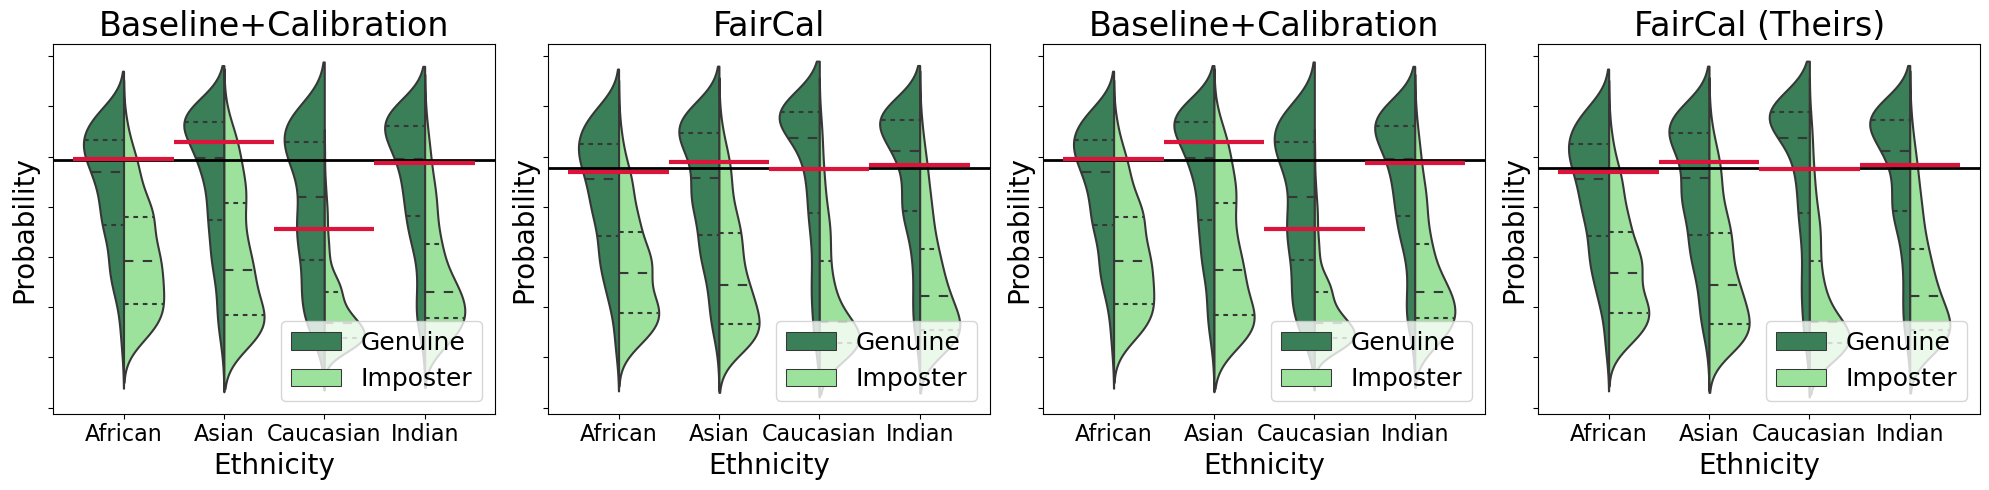

In [201]:
subgroups = ['African', 'Asian', 'Caucasian', 'Indian']
title_columns = ['Baseline+Calibration', 'FairCal', 'Baseline+Calibration', 'FairCal (Theirs)']
columns = ['baseline', 'faircal', 'baseline', 'faircal']
# title_columns = ['FairCal (Theirs)', 'GMM-25 (Ours)', 'GMM-50 (Ours)', 'GMM-100 (Ours)']
# columns = ['faircal', 'gmm-discrete25', 'gmm-discrete50', 'gmm-discrete100']


fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)

# creating a dictionary with one specific color per group:
my_pal = {"Genuine": "seagreen", "Imposter": "lightgreen"}
fpr_subgroup = {}
for i_aux, aux in enumerate(columns):
    sns.violinplot(
    x ='ethnicity',
    hue="pair",
    y=aux,
    split=True,
    data=db_fold['test'],
    scale="count",
    inner="quartile",
    ax = axes[i_aux],
    order=subgroups,
    palette=my_pal
)
    axes[i_aux].legend(loc = 'lower right', fontsize=legend_fontsize)
    axes[i_aux].set_xlabel('Ethnicity', fontsize=label_fontsize)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    if aux == 'facenet-webface':
        axes[i_aux].set_ylabel('Cosine Similarity Score', fontsize=label_fontsize)
    else:
        axes[i_aux].set_ylabel('Probability', fontsize=label_fontsize)
    labels = [item.get_text() for item in axes[i_aux].get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    axes[i_aux].set_yticklabels(empty_string_labels)

    axes[i_aux].tick_params(axis='x', labelsize=ticks_fontsize-2)

    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    
    axes[i_aux].axhline(global_thr[np.argmin(np.abs(global_fpr-0.05))],
                    ls='-',
                    linewidth=2,
                    alpha = 1,
                    c='black')
    fpr_subgroup[aux] = {}
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].hlines(y = thr[np.argmin(np.abs(fpr-0.05))],
                       ls='-',
                       color='crimson',
                       linewidth=3,
                       xmin =j-0.5,
                       xmax = j+1-0.5)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print("%s - %s FPR = %1.3f"%(title_columns[i_aux], subgroup, fpr_subgroup[aux][j]))
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_score_distributions_fpr_thresholds.png', bbox_inches='tight')

In [51]:
db_fold['test']

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id1,num1,id2,num2,ethnicity,pair,same,...,test_cluster_1,test_cluster_2,baseline,oracle,fsn,faircal,gmm-discrete,gmm-discrete25,gmm-discrete50,gmm-discrete100
2998,3000,3000,3000,m.0bwh6b,3,m.0bwh6b,1,African,Genuine,True,...,21,51,0.402229,0.356863,0.314190,0.356239,0.436027,0.303946,0.388526,0.358126
2999,3001,3001,3001,m.01wf_f3,1,m.01wf_f3,2,African,Genuine,True,...,21,53,0.341500,0.300508,0.401456,0.364887,0.318289,0.353800,0.331652,0.387512
3000,3002,3002,3002,m.03f7dxh,3,m.03f7dxh,1,African,Genuine,True,...,15,15,0.836260,0.802563,0.878749,0.826979,0.833481,0.871728,0.845993,0.836272
3001,3003,3003,3003,m.04rlb8,3,m.04rlb8,2,African,Genuine,True,...,90,11,0.428562,0.381677,0.331863,0.295110,0.359228,0.319833,0.336587,0.293292
3002,3004,3004,3004,m.0c7nfp,2,m.0c7nfp,1,African,Genuine,True,...,73,43,0.727128,0.682049,0.607550,0.698514,0.649614,0.662260,0.719413,0.695558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21589,21595,21595,21595,m.0krsd,3,m.04jfczz,3,Indian,Imposter,False,...,17,17,0.344057,0.313049,0.206421,0.346547,0.341661,0.404951,0.342453,0.325123
21590,21596,21596,21596,m.027bp7c,3,m.0744sc,2,Indian,Imposter,False,...,77,5,0.165881,0.140632,0.149758,0.185210,0.129816,0.131953,0.138725,0.134503
21591,21597,21597,21597,m.04yb7nl,1,m.02s6mz,4,Indian,Imposter,False,...,63,79,0.359463,0.328595,0.534958,0.344311,0.417857,0.482375,0.484883,0.254701
21592,21598,21598,21598,m.02qhg7v,2,m.0gf8pjf,4,Indian,Imposter,False,...,59,3,0.302353,0.271418,0.292333,0.179681,0.147171,0.274789,0.204316,0.141164


#### Fairness plots (Global FPR vs Subgroup-specific FPR)

Baseline African - 5.7
Baseline Asian - 9.7
Baseline Indian - 4.3
Baseline Caucasian - 0.3
FairCal (Theirs) African - 4.0
FairCal (Theirs) Asian - 6.4
FairCal (Theirs) Indian - 5.3
FairCal (Theirs) Caucasian - 4.7
GMM 25 (Ours) African - 4.7
GMM 25 (Ours) Asian - 5.0
GMM 25 (Ours) Indian - 6.0
GMM 25 (Ours) Caucasian - 4.3
GMM 50 (Ours) African - 4.3
GMM 50 (Ours) Asian - 4.4
GMM 50 (Ours) Indian - 5.3
GMM 50 (Ours) Caucasian - 6.0
GMM 100 (Ours) African - 4.7
GMM 100 (Ours) Asian - 5.7
GMM 100 (Ours) Indian - 5.0
GMM 100 (Ours) Caucasian - 4.7


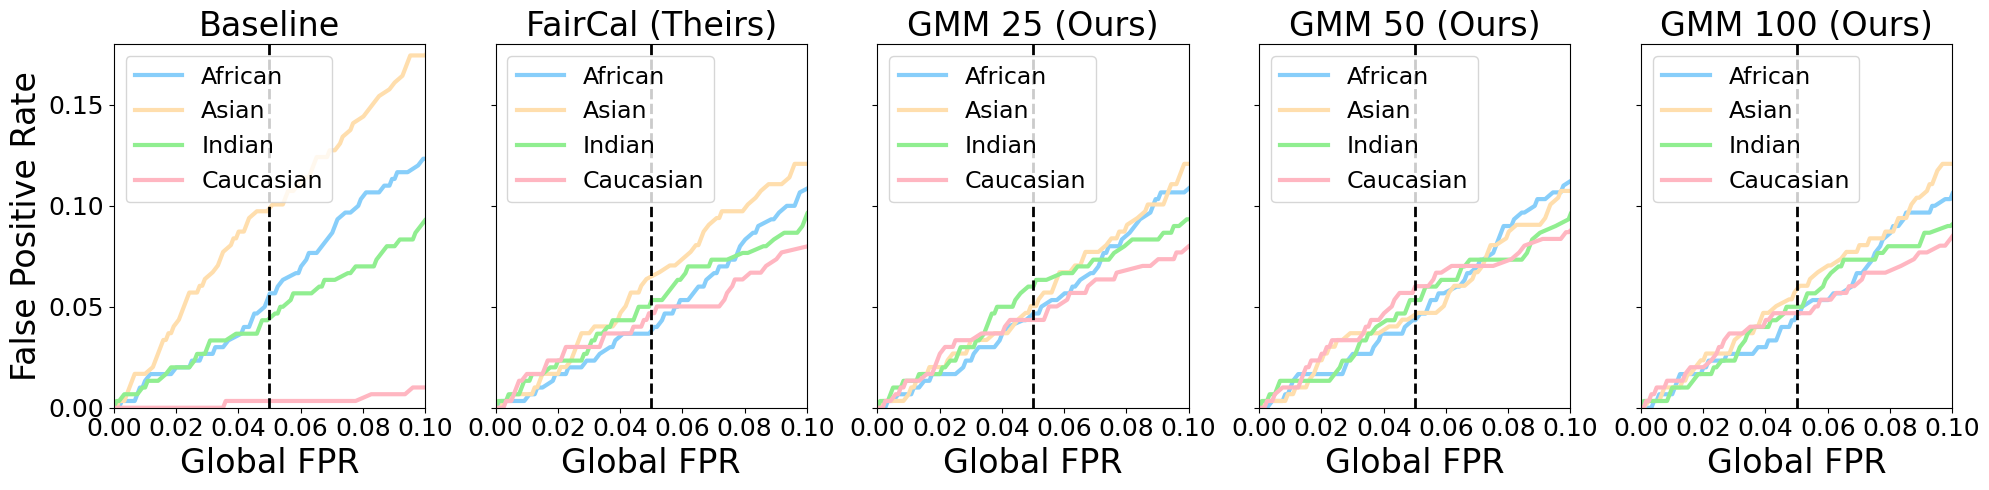

In [223]:
feature = 'facenet-webface'
metrics = {'aad': {}, 'mad': {}, 'std': {}}
subgroups = ['African', 'Asian', 'Indian', 'Caucasian']
# title_columns = ['Baseline', 'FairCal (Theirs)', 'GMM 25 (Ours)', 'GMM 50 (Ours)', 'GMM 100 (Ours)']
# approaches = ['baseline', 'faircal', 'gmm-discrete25', 'gmm-discrete50', 'gmm-discrete100']
title_columns = ['Baseline', 'FairCal (Theirs)', 'GMM 25 (Ours)', 'GMM 50 (Ours)', 'GMM 100 (Ours)']
approaches = ['baseline', 'faircal', 'gmm-discrete25', 'gmm-discrete50', 'gmm-discrete100']
# title_columns = ['Baseline', 'Baseline+Calibration']
# approaches = ['facenet-webface', 'baseline']

cols = ['lightskyblue', 'navajowhite', 'lightgreen', 'lightpink']
fig, axes = plt.subplots(1,len(approaches),figsize=(20,5), sharey=True)
for i_approach, approach in enumerate(approaches):
    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][approach],
            drop_intermediate=False,
            pos_label = True)
    
    fpr_subgroup[approach] = np.zeros(len(subgroups))
    
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][approach][select],
            drop_intermediate=False,
            pos_label = True)
        
        axes[i_approach].plot(np.interp(thr,global_thr[::-1],global_fpr[::-1]),fpr, linewidth=3, color=cols[j])
        
        fpr_subgroup[approach][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print('%s %s - %1.1f'%(title_columns[i_approach],subgroup, fpr_subgroup[approach][j]))
    metrics['aad'][approach] = np.mean(np.abs(fpr_subgroup[approach]-np.mean(fpr_subgroup[approach])))
    metrics['mad'][approach] = np.max(np.abs(fpr_subgroup[approach]-np.mean(fpr_subgroup[approach])))
    metrics['std'][approach] = np.std(fpr_subgroup[approach])
    # print('AAD = %1.2f'%metrics['aad']['bmc'])
    # print('MAD = %1.2f'%metrics['mad']['bmc'])
    # print('STD = %1.2f'%metrics['std']['bmc'])
    axes[i_approach].plot([0.05, 0.05],[0,1],'--k',linewidth=2)
    axes[i_approach].legend(subgroups,loc = 'upper left', prop={'size': 17})
    axes[i_approach].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
    axes[i_approach].set_xlim(0,0.1)
    axes[i_approach].set_ylim(0,0.18)
    axes[i_approach].set_title(title_columns[i_approach], fontsize=title_fontsize)
    axes[i_approach].set_xlabel('Global FPR', fontsize=title_fontsize)
    if i_approach == 0:
        axes[i_approach].set_ylabel('False Positive Rate', fontsize=title_fontsize)
    axes[i_approach].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_thr_vs_fpr.png', bbox_inches='tight')

Facenet-webface gave the residual = 49.89.
Fsn gave the residual = 3.84.
Oracle gave the residual = 3.32.
Faircal gave the residual = 3.55.
Gmm-discrete25 gave the residual = 2.3800000000000003.
Gmm-discrete50 gave the residual = 1.58.
Gmm-discrete100 gave the residual = 1.9800000000000002.


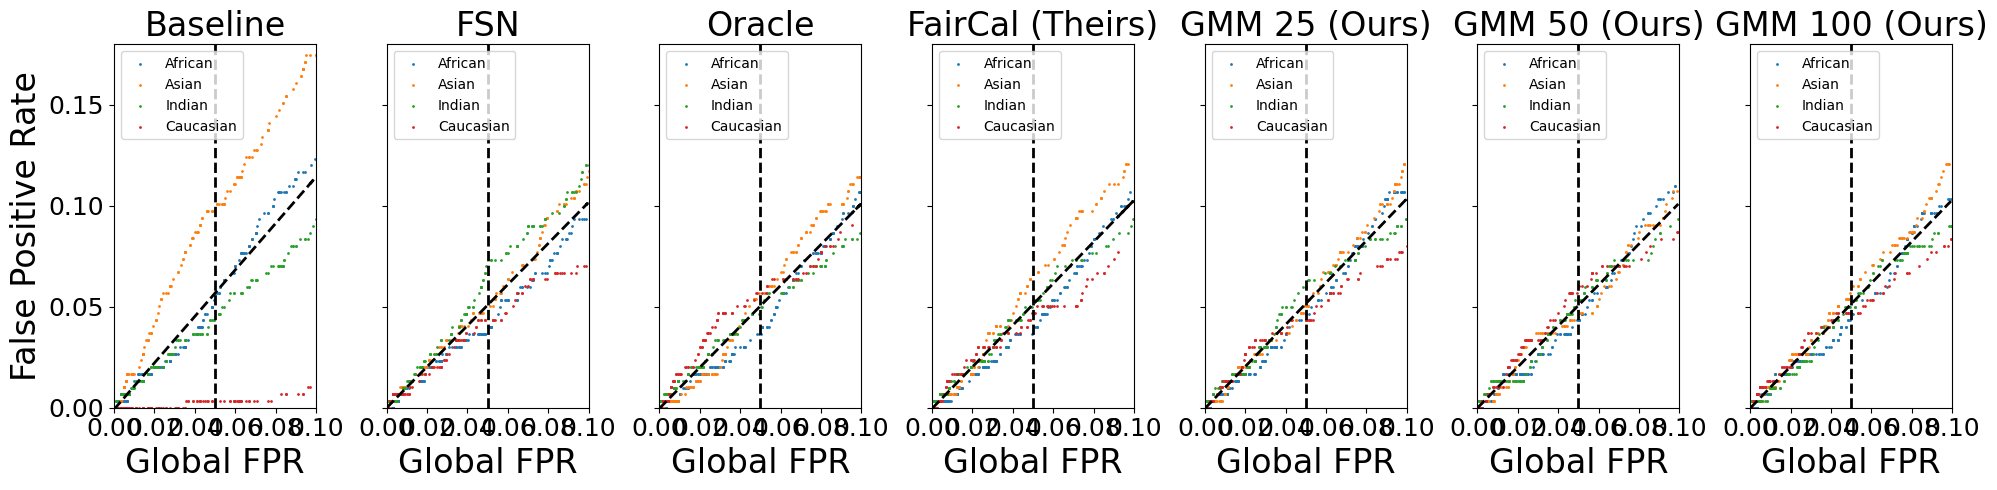

In [227]:
# Plotting only one plot at a time

# A metric for fairness_calibration
import itertools



feature = 'facenet-webface'
metrics = {'aad': {}, 'mad': {}, 'std': {}}
subgroups = ['African', 'Asian', 'Indian', 'Caucasian']
title_columns = ['Baseline', 'FSN', 'Oracle', 'FairCal (Theirs)', 'GMM 25 (Ours)', 'GMM 50 (Ours)', 'GMM 100 (Ours)']
approaches = ['facenet-webface', 'fsn', 'oracle', 'faircal', 'gmm-discrete25', 'gmm-discrete50', 'gmm-discrete100']


fig, axes = plt.subplots(1,len(approaches),figsize=(20,5), sharey=True)
for i_approach, approach in enumerate(approaches):
    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][approach],
            drop_intermediate=False,
            pos_label = True)
    
    fpr_subgroup[approach] = np.zeros(len(subgroups))
    
    x = []
    y = []
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][approach][select],
            drop_intermediate=False,
            pos_label = True)
        
        x_current = np.interp(thr,global_thr[::-1],global_fpr[::-1])
        cond = x_current < 0.1       

        x.append(x_current[cond])
#         x.append(x_current)
        
        y_current = fpr
#         y.append(y_current)
        y.append(y_current[cond])

        
        axes[i_approach].scatter(x_current, y_current, s=1)
        
        fpr_subgroup[approach][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]

    
    x = np.hstack(x)
    y = np.hstack(y)

#     x = np.array(list(itertools.chain(*x)))
#     y = np.array(list(itertools.chain(*y)))

    coefs, residual, _, _, _ = np.polyfit(x, y, deg=1, full=True)

    a = coefs[0]
    b = coefs[1]
    y_pred = a * x + b
    axes[i_approach].plot(x, y_pred, color='black', linestyle='--', linewidth=2)
    print(f'{approach.capitalize()} gave the residual = {round(residual[0], 4)*100}.')
    
    metrics['aad'][approach] = np.mean(np.abs(fpr_subgroup[approach]-np.mean(fpr_subgroup[approach])))
    metrics['mad'][approach] = np.max(np.abs(fpr_subgroup[approach]-np.mean(fpr_subgroup[approach])))
    metrics['std'][approach] = np.std(fpr_subgroup[approach])
  
    axes[i_approach].plot([0.05, 0.05],[0,1],'--k',linewidth=2)

    axes[i_approach].legend(subgroups,loc = 'upper left')
    axes[i_approach].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
    axes[i_approach].set_xlim(0,0.1)
    axes[i_approach].set_ylim(0,0.18)
    axes[i_approach].set_title(title_columns[i_approach], fontsize=title_fontsize)
    axes[i_approach].set_xlabel('Global FPR', fontsize=title_fontsize)
    if i_approach == 0:
        axes[i_approach].set_ylabel('False Positive Rate', fontsize=title_fontsize)
    axes[i_approach].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.tight_layout()

864
1.0165036810584958 -0.00012773244814910642
0.11
Gmm-discrete50 gave the residual = 0.016.


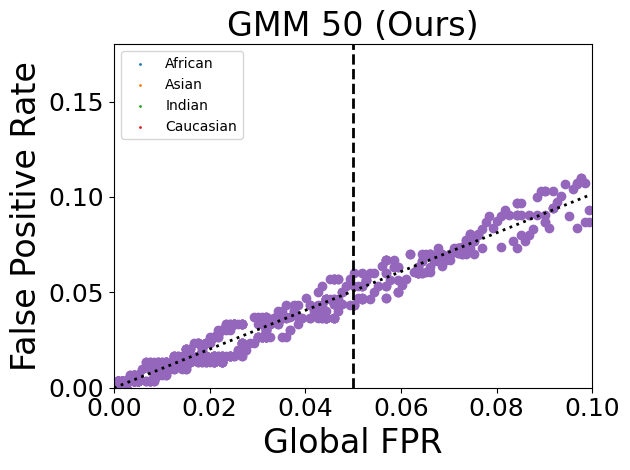

In [162]:
# A metric for fairness_calibration
import itertools



# feature = 'facenet-webface'
# metrics = {'aad': {}, 'mad': {}, 'std': {}}
# subgroups = ['African', 'Asian', 'Indian', 'Caucasian']
# title_columns = ['Baseline', 'FSN', 'Oracle', 'FairCal (Theirs)', 'GMM 25 (Ours)', 'GMM 50 (Ours)', 'GMM 100 (Ours)']
# approaches = ['facenet-webface', 'fsn', 'oracle', 'faircal', 'gmm-discrete25', 'gmm-discrete50', 'gmm-discrete100']

title_columns = ['GMM 50 (Ours)']
approaches = ['gmm-discrete50']

fig, axes = plt.subplots(1,len(approaches), sharey=True)
axes = [axes]
for i_approach, approach in enumerate(approaches):
    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][approach],
            drop_intermediate=False,
            pos_label = True)
    
    fpr_subgroup[approach] = np.zeros(len(subgroups))
    
    x = []
    y = []
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][approach][select],
            drop_intermediate=False,
            pos_label = True)
        
        x_current = np.interp(thr,global_thr[::-1],global_fpr[::-1])
        cond = x_current < 0.1       
        x.append(x_current[cond])
        
        y_current = fpr
        y.append(y_current[cond])
        
        axes[i_approach].scatter(x_current, y_current, s=1)
        
        fpr_subgroup[approach][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]

    
    x = np.hstack(x)
    print(len(x))
    y = np.hstack(y)
    axes[i_approach].scatter(x, y)

#     x = np.array(list(itertools.chain(*x)))
#     y = np.array(list(itertools.chain(*y)))

    coefs, residual, _, _, _ = np.polyfit(x, y, 1, full=True)

    a = coefs[0]
    b = coefs[1]
    y_pred = a * x + b
    print(a, b)
    print(max(y))
    axes[i_approach].plot(x, y_pred, color='black', linestyle=':', linewidth=2)
    print(f'{approach.capitalize()} gave the residual = {round(residual[0], 3)}.')
    
#     metrics['aad'][approach] = np.mean(np.abs(fpr_subgroup[approach]-np.mean(fpr_subgroup[approach])))
#     metrics['mad'][approach] = np.max(np.abs(fpr_subgroup[approach]-np.mean(fpr_subgroup[approach])))
#     metrics['std'][approach] = np.std(fpr_subgroup[approach])
  
    axes[i_approach].plot([0.05, 0.05],[0,1],'--k',linewidth=2)

    axes[i_approach].legend(subgroups,loc = 'upper left')
    axes[i_approach].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
    axes[i_approach].set_xlim(0,0.1)
    axes[i_approach].set_ylim(0,0.18)
    axes[i_approach].set_title(title_columns[i_approach], fontsize=title_fontsize)
    axes[i_approach].set_xlabel('Global FPR', fontsize=title_fontsize)
    if i_approach == 0:
        axes[i_approach].set_ylabel('False Positive Rate', fontsize=title_fontsize)
    axes[i_approach].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.tight_layout()

In [156]:
# #define data
# # x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
# # y = np.array([2, 5, 6, 7, 9, 12, 16, 19])

# #find line of best fit
# a, b = np.polyfit(x, y, 1)

# #add points to plot
# plt.scatter(x, y, color='purple')

# #add line of best fit to plot
# plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)

# #add fitted regression equation to plot
# plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)